In [1]:
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Lambda
from tensorflow.keras import Sequential, Model
from kapre import backend
from kapre.time_frequency import STFT, Magnitude, ApplyFilterbank, MagnitudeToDecibel
from kapre.composed import get_melspectrogram_layer
from scipy.io import wavfile
import sys
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from augmentation_layers import RandomFreqMask, RandomTimeMask
np.set_printoptions(threshold=10000, precision=10)

In [2]:
input_shape=(22050,1)
n_fft=2048
win_length=int(25 * 22050 / 1000)
hop_length=int(10 * 22050 / 1000)
window_name=None
pad_begin=False
pad_end=True
sample_rate=22050
n_mels=128
mel_f_min=0.0
mel_f_max=None
mel_htk=False
mel_norm='slaney'
return_decibel=True
db_amin=1e-5
db_ref_value=1.0
db_dynamic_range=80.0
input_data_format='channels_last'
output_data_format='channels_last'

In [3]:
backend.validate_data_format_str(input_data_format)
backend.validate_data_format_str(output_data_format)
waveform_to_stft = STFT(
    input_shape=input_shape,
    n_fft=2048,
    win_length=win_length,
    hop_length=hop_length,
    window_name=window_name,
    pad_begin=pad_begin,
    pad_end=pad_end,
    input_data_format=input_data_format,
    output_data_format=output_data_format,
)
stft_to_stftm = Magnitude()
kwargs = {
    'sample_rate': sample_rate,
    'n_freq': n_fft // 2 + 1,
    'n_mels': n_mels,
    'f_min': mel_f_min,
    'f_max': mel_f_max,
    'htk': mel_htk,
    'norm': mel_norm,
}
stftm_to_melgram = ApplyFilterbank(
    type='mel', filterbank_kwargs=kwargs, data_format=output_data_format
)
layers = [waveform_to_stft, stft_to_stftm, stftm_to_melgram]
if return_decibel:
    mag_to_decibel = MagnitudeToDecibel(
        ref_value=db_ref_value, amin=db_amin, dynamic_range=db_dynamic_range
    )
    layers.append(mag_to_decibel)
def norm_fn(x):
    x = tf.cast(x, tf.float32)
    mins = tf.reshape(tf.reduce_min(x, axis=[1, 2]), (-1, 1, 1))
    maxes = tf.reshape(tf.reduce_max(x, axis=[1, 2]), (-1, 1, 1))
    return 2 * (x - mins) / (maxes - mins) - 1
norm_layer = Lambda(norm_fn)
dataset = np.array(pickle.load(open('ds.pkl','rb')))

In [11]:
mag_to_decibel(stftm_to_melgram(stft_to_stftm(waveform_to_stft(norm_layer(dataset[0])))))

<tf.Tensor: shape=(15, 101, 128, 1), dtype=float32, numpy=
array([[[[ -3.8753777 ],
         [ -7.4345036 ],
         [-15.341567  ],
         ...,
         [-50.        ],
         [-50.        ],
         [-50.        ]],

        [[ -3.871038  ],
         [ -7.424719  ],
         [-15.325297  ],
         ...,
         [-47.808765  ],
         [-48.68805   ],
         [-47.81392   ]],

        [[ -3.8833997 ],
         [ -7.4634523 ],
         [-15.405401  ],
         ...,
         [-49.48317   ],
         [-49.520954  ],
         [-47.406487  ]],

        ...,

        [[ -3.8704028 ],
         [ -7.346673  ],
         [-15.038676  ],
         ...,
         [-39.2105    ],
         [-39.225826  ],
         [-39.237465  ]],

        [[ -6.1569977 ],
         [ -7.078888  ],
         [ -8.851494  ],
         ...,
         [-29.811584  ],
         [-29.827248  ],
         [-29.838875  ]],

        [[-25.826948  ],
         [-25.716688  ],
         [-25.75535   ],
         ...,
        

In [9]:
stage3s = np.array([stftm_to_melgram(stft_to_stftm(waveform_to_stft(norm_layer(batch)))) for batch in dataset])

In [17]:
stage3s.shape

101

In [18]:
np.max(stage3s)

13.713059

In [19]:
np.min(stage3s)

4.1761712e-11

In [20]:
np.percentile(stage3s,2)

7.69109789189315e-08

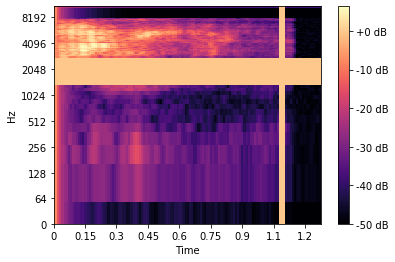

In [35]:
stage4s = mag_to_decibel(stftm_to_melgram(stft_to_stftm(waveform_to_stft(norm_layer(dataset[0])))))

rfm = RandomFreqMask(15, 0.2, 0.75)
rtm = RandomTimeMask(15, 0.2, 0.75)
arr2 = np.array(rfm(rtm(stage4s))[0])
arr2 = arr2.reshape(101,128)
librosa.display.specshow(arr2,sr=22050,hop_length=hop_length,x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

In [44]:
stage4s.shape

TensorShape([15, 101, 128, 1])

In [272]:
a = norm_layer(wav)
np.max(a)

1.0

In [36]:
tf.random.Generator.from_seed(1).uniform(shape=())

<tf.Tensor: shape=(), dtype=bool, numpy=True>